# Author: Olzhas Yergali, 2023
Schweinfurt, Germany


---



### This notebook is dedicated to implement design described by the following paper, implementing learning process of a DNN based on the two Assumptions from the same paper:


> Takano. "Self-Supervision is All You Need for Solving Rubik’s Cube", 2022 [https://arxiv.org/abs/2106.03157]



---



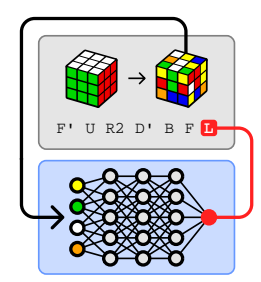
[1, Depiction of a random scrambling of a 3x3x3 cube for training.]

### Asumption from the paper: <br>
When random paths connect two nodes,
more optimal moves are more often the first move. Randomly scrambled, in absence of redundant moves that cancel each other, the scramble is biased toward the optimal solution.



Most of the following code is written by Takano, but the model was trained and built in PyTorch, whereas I decided to stick with Tensorflow.

The following code could be divided on these sections:


1. Imports.
2. Graphing Functions.
3. 2x2x2 Cube Environment .
4. Model creation and compilation.
5. Using TF Data Sequence for creating data stream of states and moves of the cube.
6. Training the model on 10<sup>5</sup> different scrambles, resulting the model to see 11*10<sup>5</sup> states, which are not necessarily unique.
7. Implementation of a Beam Search, which is used to look through a lot of candidates along the way of solving a cube. The beam widths used were 2<sup>8</sup> and 2<sup>12</sup>.
8. Using the Beam Search and the model for trying to solve a 100 scrambled cubes.
9. Plotting the results.





# 1. Imports.


In [ ]:
import time
import itertools
import numpy as np
from fractions import Fraction
from tqdm import tqdm
import pickle

import os
import copy

import tensorflow as tf

# 2. Graphing Functions.


In [2]:
import matplotlib.pyplot as plt
from cycler import cycler
plt.rcParams["axes.prop_cycle"] = cycler(color=["#212121", "#2180FE", "#EB4275"])

def plt_history(h):
    fig, axes = plt.subplots(1, 1, figsize=[4, 4])
    axes.plot(h)
    axes.set_xscale("log")
    axes.set_title("Loss")
    plt.show()

def regression_coef(x, y):
    coef = np.array(y) / np.array(x)
    coef = np.mean(np.squeeze(coef))
    return coef

def plot_result(solutions_all, num_nodes_all, times_all):
    fig, ax = plt.subplots(2, 3, figsize=(16, 9))
    ax = ax.ravel()
    for i, result in enumerate([solutions_all, num_nodes_all, times_all]):
        result = [e for e in result if e is not None]
        if i == 0:  # soltions
            result = [len(e) for e in result if e is not None]
            ax[i].axvline(
                np.mean(result),
                color="#00ffff",
                label=f"mean={round(np.mean(result),3)}",
            )
            result = {i: result.count(i)
                      for i in range(min(result), max(result) + 1)}
            ax[i].bar(
                result.keys(),
                result.values(),
                width=1.0,
                label=f"Success: {len([len(e) for e in solutions_all if e is not None])}/{len(solutions_all)}",
            )
            ax[i].legend()
            ax[i].set_xlabel("Solution length")
            ax[i].set_ylabel("Frequency")
        else:
            ax[i].hist(result)
            ax[i].axvline(
                np.mean(result),
                color="#00ffff",
                label=f"mean={round(np.mean(result),3)}",
            )
            ax[i].legend()
            if i == 1:
                ax[i].set_xlabel("No. of nodes")
            else:
                ax[i].set_xlabel("Calculation time (s)")

    solution_lengths, num_nodes, times = [
        [e for e in result if e is not None]
        for result in [solutions_all, num_nodes_all, times_all]
    ]
    solution_lengths = [len(e) for e in solution_lengths]

    for (xlabel, ylabel), (x, y) in [
        [("Solution lengths", "No. of nodes"), (solution_lengths, num_nodes)],
        [("No. of nodes", "Calculation time (s)"), (num_nodes, times)],
        [("Calculation time (s)", "Solution lengths"), (times, solution_lengths)],
    ]:
        i += 1
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        x_range = np.linspace(0, max(x), 100)
        ax[i].plot(
            x_range,
            x_range * regression_coef(x, y),
            label=f"slope={round(regression_coef(x, y), 5)}",
            color="#00ffff",
        )
        ax[i].scatter(x, y)
        ax[i].legend()

    plt.show()


# 3. 2x2x2 Cube Environment .
<br>
The 2x2x2 in the Takano paper was used to reflect feasibility of the assumption stated above, thus, Takano has implemented it in order to go through every possible state of this cube, and analyze it for optimality. 
<br><br>
Here I am implementing it to solve it with the help of a net. That is why I have not implemented brute force through every state, but used it for training and testing the net.
<br><br>
The motivation for that decision is testing and implementing knowledge I obtained from these papers:

* Takano, Self-Supervision is All You Need for Solving Rubik’s Cube, 2022.
* Agostinelli et al., Solving the Rubik’s cube with deep reinforcement learning and search, 2019.
* McAleer et al., Solving the Rubik’s Cube Without Human
Knowledge, 2018.

but using less time for training and testing.

In [3]:
import random
import numpy as np


class Cube2(object):
    def __init__(self, metric="HTM"):
        self.DTYPE = np.int64
        self.metric = metric

        # define state and goal
        self.reset()  # state
        self.goal = np.arange(0, 4*6, dtype=self.DTYPE) // 4

        # define moves
        # faces and turns
        """
            As we compute 'relative' transition of states, we turn U (Up), R (Right), F (Front) faces only.
            Accordingly, the Left-Down-Back piece is fixed.
        """
        faces = ['U', 'R', 'F']
        degrees = ['', "'", '2']  # [90 degrees clockwise, 90 degrees counter-clockwise, 180 degrees]
        degrees_inference = ["'", '', '2']

        # cartesian product
        self.moves = [f"{f}{n}" for f in faces for n in degrees]
        self.moves_inference = [f"{f}{n}" for f in faces for n in degrees_inference]
        # two subsequent moves on a same face are unnecessary.
        self.moves_subsequent = {
            m: [v for v in self.moves if v[0] != m[0]] for m in self.moves
        }
        self.__vectorize_moves()

    def reset(self):
        # self.state = self.goal.copy()
        self.state = np.arange(0, 4*6, dtype=self.DTYPE) // 4

    def is_solved(self):
        return np.all(self.state == self.goal)

    def state_to_batch(self):
        return np.expand_dims(self.state, axis=0)

    def finger(self, move):
        self.state[self.sticker_target[move]
                   ] = self.state[self.sticker_source[move]]

    def finger_ix(self, ix):
        self.state[self.sticker_target_ix[ix]
                   ] = self.state[self.sticker_source_ix[ix]]

    def __vectorize_moves(self):
        '''
            This method defines "self.sticker_target" and "self.sticker_source" to manage sticker colors (target is replaced by source).
            They define indices of target and source stickers so that the moves can be vectorized.

            colors:
                    0 0
                    0 0
                2 2 5 5 3 3 4 4
                2 2 5 5 3 3 4 4
                    1 1
                    1 1
            order of stickers on each face:
                 1  3
                [0] 2

            indices of state (each starting with 4*(n-1)):
                         1   3
                        [0]  2
                 9  11  21  23   13  15  17  19
                [8] 10 [20] 22  [12] 14 [16] 18
                         5   7
                        [4]  6
        '''
        self.sticker_target, self.sticker_source = dict(), dict()

        self.sticker_replacement = {
            # Sticker A is replaced by another sticker at index B -> A:B
            'U': {
                0: 2,
                1: 0,
                2: 3,
                3: 1,
                9: 21,
                11: 23,
                13: 17,
                15: 19,
                17: 9,
                19: 11,
                21: 13,
                23: 15
            },
            'R': {
                2: 22,
                3: 23,
                7: 16,
                6: 17,
                12: 14,
                13: 12,
                14: 15,
                15: 13,
                16: 3,
                17: 2,
                22: 6,
                23: 7
            },
            'F': {
                0: 10,
                2: 11,
                5: 12,
                7: 13,
                10: 7,
                11: 5,
                12: 2,
                13: 0,
                20: 22,
                21: 20,
                22: 23,
                23: 21
            }
        }
        for m in self.moves:
            if len(m) == 1:
                assert m in self.sticker_replacement
            else:
                if "'" in m:
                    self.sticker_replacement[m] = {
                        v: k for k, v in self.sticker_replacement[m[0]].items()}
                elif "2" in m:
                    self.sticker_replacement[m] = {
                        k: self.sticker_replacement[m[0]][v] for k, v in self.sticker_replacement[m[0]].items()}
                else:
                    raise

            self.sticker_target[m] = list(self.sticker_replacement[m].keys())
            self.sticker_source[m] = list(self.sticker_replacement[m].values())

            for i, idx in enumerate(self.sticker_target[m]):
                assert self.sticker_replacement[m][idx] == self.sticker_source[m][i]

        self.sticker_source_ix = {
            ix: self.sticker_source[m] for ix, m in enumerate(self.moves)}
        self.sticker_target_ix = {
            ix: self.sticker_target[m] for ix, m in enumerate(self.moves)}

    def apply_scramble(self, scramble):
        if isinstance(scramble, str):
            scramble = scramble.split()
        for m in scramble:
            if m[-1] == '2':
                for _ in range(2):
                    self.finger(m[0])
            else:
                self.finger(m)

    def scrambler(self, scramble_length):
        """
        A generator function yielding the state and scramble
        """
        while True:
            # reset the self.state, scramble, and retun self.state and scramble moves
            self.reset()
            scramble = []

            for i in range(scramble_length):
                if i:
                    last_move = scramble[-1]
                    if i > 1:  # N(>=3)th moves
                        while True:
                            move = random.choice(self.moves_subsequent[last_move])
                            if self.metric == "QTM":
                                if scramble[-2] == last_move == move:
                                    # Two mutually canceling moves in a row
                                    continue
                                else:
                                    break
                            elif self.metric == "HTM":
                                if scramble[-2][0] == move[0]:
                                    # Two mutually canceling moves sandwiching an opposite face move
                                    continue
                                else:
                                    break
                            else:
                                raise
                    else:  # 2nd move
                        move = random.choice(self.moves_subsequent[last_move])
                else:  # 1st move
                    move = random.choice(self.moves)

                self.finger(move)
                scramble.append(move)

                yield self.state, move

In [4]:
"""
  torch model for 3x3x3 by Takano:

  self.one_hot = nn.functional.one_hot
  self.Stack = nn.Sequential(
      LinearBlock(324, 5000),
      LinearBlock(5000, 1000),
      ResidualBlock(1000),
      ResidualBlock(1000),
      ResidualBlock(1000),
      ResidualBlock(1000),
  )
  self.Prediction = nn.Linear(1000, len(env.moves))
"""

'\n  torch model for 3x3x3 by Takano:\n\n  self.one_hot = nn.functional.one_hot\n  self.Stack = nn.Sequential(\n      LinearBlock(324, 5000),\n      LinearBlock(5000, 1000),\n      ResidualBlock(1000),\n      ResidualBlock(1000),\n      ResidualBlock(1000),\n      ResidualBlock(1000),\n  )\n  self.Prediction = nn.Linear(1000, len(env.moves))\n'

In [5]:
env = Cube2()
env.reset()
env.state

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5])

# 4. Model creation and compilation.
The model is identical to the one implemented by Takano.

In [6]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(ResidualBlock, self).__init__()
        self.num_outputs = num_outputs
        self.lin1 = tf.keras.layers.Dense(num_outputs)
        self.lin2 = tf.keras.layers.Dense(num_outputs)

    def call(self, inputs):
        x = self.lin1(inputs)
        x = self.lin2(x)
        x = tf.keras.layers.Add()([inputs, x])
        return x


In [7]:
model = tf.keras.Sequential(
    layers = [
        tf.keras.Input(shape=(144,)),               # 144 = 6 * 4 * 6 | sides * cublets * colors
        tf.keras.layers.Dense(5000, 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1000, 'relu'),
        tf.keras.layers.BatchNormalization(),
        ResidualBlock(1000),
        ResidualBlock(1000),
        ResidualBlock(1000),
        ResidualBlock(1000),
        tf.keras.layers.Dense(len(env.moves)),
    ]
)

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,
                                                           label_smoothing=0.1),
              metrics=['accuracy']
              )

In [9]:
print(tf.test.gpu_device_name())

/device:GPU:0


# 5. Using TF Data Sequence for creating data stream of states and moves of the cube.


In [96]:
class BatchSequence(tf.keras.utils.Sequence):
    def __init__(self, batch_size=100, scramble_length=11, training_samples=1000):
        self.batch_size = batch_size
        self.env = Cube2()
        self.generator = self.env.scrambler(scramble_length=scramble_length)
        self.training_samples = training_samples
        self.scramble_length = scramble_length
        self.data_generated = False

    def __len__(self):
        return int(tf.math.ceil(self.training_samples*self.scramble_length/self.batch_size))

    def __getitem__(self, idx):
        if not self.data_generated:
            self.gen_data()

        low = self.batch_size*idx
        high = min(self.batch_size*(idx+1), len(self.states))

        states = self.states[low:high]
        last_moves = self.last_moves[low:high]
        
        return states, last_moves

    def gen_data(self):
        states = np.zeros((self.scramble_length*self.training_samples, 4*6))
        last_moves = np.zeros((self.scramble_length*self.training_samples, 1))
        for i in range(self.training_samples):
            self.env.reset()
            for j in range(self.scramble_length):
                _, last_move = next(self.generator)
                states[i*self.scramble_length + j, :] = self.env.state
                last_moves[i*self.scramble_length + j] = env.moves.index(last_move)

        self.last_moves = tf.keras.utils.to_categorical(np.array(last_moves), len(self.env.moves))
        self.states = tf.reshape(tf.one_hot(states, 6), (-1, 4*6*6))

        self.data_generated = True

In [97]:
data_sequence = BatchSequence(100, 11, 100000)

In [98]:
a = data_sequence.__getitem__(1)
print(a[0].shape, a[1].shape) 
# Expected: (_, 144) (_, 9), where '_' is batch_size

(100, 144) (100, 9)


# 6. Training the model on 10<sup>5</sup> different scrambles, resulting the model to see 11*10<sup>5</sup> states, which are not necessarily unique.
<br>
11*10<sup>5</sup> is approximately the third of all the possible states. While it is a huge amount, there still is room for an error, thus the net is not going to be overfit for the set.
<br><br>
While just one state is equivalent into 6 other states due to symmetry, meaning the third of all the possible states is more than enough to explore the whole space of the problem.
<br><br>
Even though there is a problem of possible covering the whole space of the problem, I believe it is not doing that because I had to finetune the net, rewrite the Data Sequence in order to consistently solve the cube from any state.

In [99]:
history = model.fit(data_sequence)

11000/11000 [==============================] - 91s 8ms/step - loss: 1.3522 - accuracy: 0.6226


In [114]:
!mkdir -p saved_weights
# !Make sure you've got the correct path for the weights.
# My weights could not be loaded to the github, since the file size is too large.
model.save_weights('/content/saved_weights/cube2_model')

# 7. Implementation of a Beam Search, which is used to look through a lot of candidates along the way of solving a cube. The beam widths used were 2<sup>8</sup> and 2<sup>12</sup>.


In [107]:
def beam_search(
    env,
    model,
    max_depth,
    beam_width,
    __eval='softmax',
    skip_redundant_moves=True
):
    training = False
    # metrics
    num_nodes, time_0 = 0, time.time()
    candidates = [
        {"state":copy.deepcopy(env.state), "path":[], "value":1.}
    ] # list of dictionaries

    for depth in range(max_depth+1):
        # TWO things at a time for every candidate: 1. check if solved & 2. add to batch_x
        batch_x = np.zeros((len(candidates), env.state.shape[-1]), dtype=np.int64)
        for i,c in enumerate(candidates):
            c_path, env.state = c["path"], c["state"]
            if c_path:
                env.finger(c_path[-1])
                num_nodes += 1
                if env.is_solved():
                    return True, {'solutions':c_path, "num_nodes":num_nodes, "times":time.time()-time_0}
            batch_x[i, :] = env.state

        # after checking the nodes expanded at the deepest    
        if depth==max_depth:
            print("Solution not found.")
            return False, None

        # make predictions with the trained DNN
        batch_x = tf.reshape(tf.one_hot(batch_x, 6), (-1, 4*6*6))
        batch_p = model.predict(batch_x)

        # loop over candidates
        candidates_next_depth = []  # storage for the depth-level candidates storing (path, value, index).
        for i, c in enumerate(candidates):
            c_path = c["path"]
            value_distribution = batch_p[i, :] # output logits for the given state
            if __eval in ["softmax","cumprod"]:
                value_distribution = tf.nn.softmax(value_distribution)
                if __eval=="cumprod":
                    value_distribution *= c["value"] # multiply the cumulative probability so far of the expanded path

            for m, value in zip(env.moves_inference, value_distribution): # iterate over all possible moves.
                # predicted value to expand the path with the given move.

                if c_path and skip_redundant_moves:
                    if m not in env.moves_subsequent[c_path[-1]]:
                        # Two mutually canceling moves
                        continue

                # add to the next-depth candidates unless 'continue'd.
                candidates_next_depth.append({
                    'state':copy.deepcopy(c['state']),
                    "path": c_path+[m],
                    "value":value,
                })

        # sort potential paths by expected values and renew as 'candidates'
        candidates = sorted(candidates_next_depth, key=lambda item: -item['value'])
        # if the number of candidates exceed that of beam width 'beam_width'
        candidates = candidates[:beam_width]


In [102]:
!mkdir -p test_scrambles

In [103]:
env = Cube2()
test_scrambles = []

num_os_fcrambles = 100
scramble_len = 1000

for i in tqdm(range(num_os_fcrambles)):
    g = env.scrambler(scramble_len)
    moves = []
    for j in range(scramble_len):
        _, move = next(g)
        moves.append(move)
    test_scrambles.append(moves)


100%|██████████| 100/100 [00:00<00:00, 175.71it/s]


In [104]:
# !Make sure that you've got the right path for the file
with open("/content/test_scrambles/test_list_file", 'wb') as f:
    pickle.dump(test_scrambles, f)

# 8. Using the Beam Search and the model for trying to solve a 100 scrambled cubes.
Every cube is scrambled with 1000 randomly chosen moves. You can find those in the pickled file.

In [108]:
result_all = {
    "solutions":[],
    "num_nodes":[],
    "times":[]
}
for scramble in tqdm(test_scrambles, position=0):
    # reset and scramble
    env.reset()
    for scramble_move in scramble:
        env.finger(scramble_move)
    # solve
    success, result = beam_search(env, model, max_depth=22, beam_width=2**8)
    if success:
        for k in result_all.keys():
            result_all[k].append(result[k])


  0%|          | 0/100 [00:00<?, ?it/s]

8/8 [==============================] - 0s 2ms/step


  1%|          | 1/100 [00:10<17:57, 10.89s/it]

8/8 [==============================] - 0s 2ms/step


  2%|▏         | 2/100 [00:37<33:07, 20.28s/it]

8/8 [==============================] - 0s 2ms/step


  3%|▎         | 3/100 [01:08<40:11, 24.86s/it]

8/8 [==============================] - 0s 2ms/step


  4%|▍         | 4/100 [01:28<37:00, 23.13s/it]

8/8 [==============================] - 0s 2ms/step


  5%|▌         | 5/100 [01:55<38:40, 24.43s/it]

8/8 [==============================] - 0s 2ms/step


  6%|▌         | 6/100 [02:18<37:45, 24.10s/it]

8/8 [==============================] - 0s 4ms/step


  7%|▋         | 7/100 [02:42<37:01, 23.89s/it]

8/8 [==============================] - 0s 2ms/step


  8%|▊         | 8/100 [03:02<34:46, 22.68s/it]

8/8 [==============================] - 0s 3ms/step


  9%|▉         | 9/100 [03:26<34:58, 23.06s/it]

8/8 [==============================] - 0s 5ms/step


 10%|█         | 10/100 [03:53<36:36, 24.40s/it]

8/8 [==============================] - 0s 2ms/step


 11%|█         | 11/100 [04:13<34:05, 22.98s/it]

8/8 [==============================] - 0s 2ms/step


 12%|█▏        | 12/100 [04:43<36:55, 25.17s/it]

8/8 [==============================] - 0s 2ms/step


 13%|█▎        | 13/100 [05:06<35:41, 24.61s/it]

8/8 [==============================] - 0s 4ms/step


 14%|█▍        | 14/100 [05:33<36:13, 25.27s/it]

8/8 [==============================] - 0s 3ms/step


 15%|█▌        | 15/100 [05:53<33:39, 23.76s/it]

8/8 [==============================] - 0s 2ms/step


 16%|█▌        | 16/100 [06:26<37:06, 26.50s/it]

8/8 [==============================] - 0s 4ms/step


 17%|█▋        | 17/100 [06:50<35:20, 25.55s/it]

8/8 [==============================] - 0s 2ms/step


 18%|█▊        | 18/100 [07:10<32:41, 23.92s/it]

8/8 [==============================] - 0s 3ms/step


 19%|█▉        | 19/100 [07:36<33:16, 24.65s/it]

8/8 [==============================] - 0s 4ms/step


 20%|██        | 20/100 [07:53<29:57, 22.47s/it]

8/8 [==============================] - 0s 3ms/step


 21%|██        | 21/100 [08:23<32:19, 24.55s/it]

8/8 [==============================] - 0s 3ms/step


 22%|██▏       | 22/100 [08:47<31:39, 24.35s/it]

8/8 [==============================] - 0s 2ms/step


 23%|██▎       | 23/100 [09:04<28:31, 22.23s/it]

8/8 [==============================] - 0s 2ms/step


 24%|██▍       | 24/100 [09:30<29:41, 23.44s/it]

8/8 [==============================] - 0s 3ms/step


 25%|██▌       | 25/100 [09:54<29:15, 23.41s/it]

8/8 [==============================] - 0s 2ms/step


 26%|██▌       | 26/100 [10:14<27:37, 22.40s/it]

8/8 [==============================] - 0s 3ms/step


 27%|██▋       | 27/100 [10:37<27:32, 22.64s/it]

8/8 [==============================] - 0s 3ms/step


 28%|██▊       | 28/100 [11:00<27:22, 22.81s/it]

8/8 [==============================] - 0s 2ms/step


 29%|██▉       | 29/100 [11:30<29:32, 24.96s/it]

8/8 [==============================] - 0s 2ms/step


 30%|███       | 30/100 [11:59<30:31, 26.17s/it]

8/8 [==============================] - 0s 4ms/step


 31%|███       | 31/100 [12:29<31:28, 27.37s/it]

8/8 [==============================] - 0s 2ms/step


 32%|███▏      | 32/100 [13:00<32:05, 28.32s/it]

8/8 [==============================] - 0s 3ms/step


 33%|███▎      | 33/100 [13:30<32:20, 28.97s/it]

8/8 [==============================] - 0s 3ms/step


 34%|███▍      | 34/100 [14:08<34:43, 31.56s/it]

8/8 [==============================] - 0s 4ms/step


 35%|███▌      | 35/100 [14:32<31:55, 29.47s/it]

8/8 [==============================] - 0s 2ms/step


 36%|███▌      | 36/100 [14:54<29:02, 27.23s/it]

8/8 [==============================] - 0s 2ms/step


 37%|███▋      | 37/100 [15:11<25:19, 24.12s/it]

8/8 [==============================] - 0s 3ms/step


 38%|███▊      | 38/100 [15:29<22:47, 22.05s/it]

8/8 [==============================] - 0s 4ms/step


 39%|███▉      | 39/100 [15:55<23:52, 23.49s/it]

8/8 [==============================] - 0s 4ms/step


 40%|████      | 40/100 [16:20<23:43, 23.72s/it]

8/8 [==============================] - 0s 3ms/step


 41%|████      | 41/100 [16:47<24:15, 24.67s/it]

8/8 [==============================] - 0s 3ms/step


 42%|████▏     | 42/100 [17:01<20:44, 21.46s/it]

8/8 [==============================] - 0s 2ms/step


 43%|████▎     | 43/100 [17:14<18:10, 19.14s/it]

8/8 [==============================] - 0s 2ms/step


 44%|████▍     | 44/100 [17:38<19:05, 20.46s/it]

8/8 [==============================] - 0s 3ms/step


 45%|████▌     | 45/100 [17:58<18:44, 20.45s/it]

8/8 [==============================] - 0s 3ms/step


 46%|████▌     | 46/100 [18:22<19:12, 21.34s/it]

8/8 [==============================] - 0s 3ms/step


 47%|████▋     | 47/100 [18:48<20:18, 22.98s/it]

8/8 [==============================] - 0s 2ms/step


 48%|████▊     | 48/100 [19:16<21:14, 24.50s/it]

8/8 [==============================] - 0s 2ms/step


 49%|████▉     | 49/100 [19:51<23:27, 27.60s/it]

8/8 [==============================] - 0s 3ms/step


 50%|█████     | 50/100 [20:23<24:01, 28.82s/it]

8/8 [==============================] - 0s 3ms/step


 51%|█████     | 51/100 [20:38<20:15, 24.82s/it]

8/8 [==============================] - 0s 3ms/step


 52%|█████▏    | 52/100 [21:10<21:26, 26.81s/it]

8/8 [==============================] - 0s 3ms/step


 53%|█████▎    | 53/100 [21:33<20:06, 25.67s/it]

8/8 [==============================] - 0s 3ms/step


 54%|█████▍    | 54/100 [22:08<21:54, 28.58s/it]

8/8 [==============================] - 0s 3ms/step


 55%|█████▌    | 55/100 [22:42<22:35, 30.13s/it]

8/8 [==============================] - 0s 2ms/step


 56%|█████▌    | 56/100 [23:05<20:36, 28.11s/it]

8/8 [==============================] - 0s 3ms/step


 57%|█████▋    | 57/100 [23:40<21:27, 29.95s/it]

8/8 [==============================] - 0s 2ms/step


 58%|█████▊    | 58/100 [23:57<18:18, 26.17s/it]

8/8 [==============================] - 0s 4ms/step


 59%|█████▉    | 59/100 [24:21<17:30, 25.63s/it]

8/8 [==============================] - 0s 3ms/step


 60%|██████    | 60/100 [24:46<16:47, 25.18s/it]

8/8 [==============================] - 0s 2ms/step


 61%|██████    | 61/100 [25:05<15:19, 23.58s/it]

8/8 [==============================] - 0s 2ms/step


 62%|██████▏   | 62/100 [25:39<16:45, 26.46s/it]

8/8 [==============================] - 0s 3ms/step


 63%|██████▎   | 63/100 [25:46<12:48, 20.76s/it]

8/8 [==============================] - 0s 3ms/step


 64%|██████▍   | 64/100 [26:13<13:30, 22.52s/it]

8/8 [==============================] - 0s 2ms/step


 65%|██████▌   | 65/100 [26:30<12:10, 20.87s/it]

8/8 [==============================] - 0s 2ms/step


 66%|██████▌   | 66/100 [26:47<11:12, 19.79s/it]

8/8 [==============================] - 0s 3ms/step


 67%|██████▋   | 67/100 [27:13<11:59, 21.79s/it]

8/8 [==============================] - 0s 3ms/step


 68%|██████▊   | 68/100 [27:44<13:00, 24.40s/it]

8/8 [==============================] - 0s 3ms/step


 69%|██████▉   | 69/100 [28:07<12:27, 24.11s/it]

8/8 [==============================] - 0s 3ms/step


 70%|███████   | 70/100 [28:27<11:25, 22.86s/it]

8/8 [==============================] - 0s 3ms/step


 71%|███████   | 71/100 [28:51<11:07, 23.02s/it]

8/8 [==============================] - 0s 2ms/step


 72%|███████▏  | 72/100 [29:14<10:47, 23.14s/it]

8/8 [==============================] - 0s 3ms/step


 73%|███████▎  | 73/100 [29:43<11:09, 24.80s/it]

8/8 [==============================] - 0s 3ms/step


 74%|███████▍  | 74/100 [30:08<10:51, 25.08s/it]

8/8 [==============================] - 0s 5ms/step


 75%|███████▌  | 75/100 [30:22<09:02, 21.72s/it]

8/8 [==============================] - 0s 3ms/step


 76%|███████▌  | 76/100 [30:54<09:49, 24.58s/it]

8/8 [==============================] - 0s 3ms/step


 77%|███████▋  | 77/100 [31:11<08:34, 22.36s/it]

8/8 [==============================] - 0s 3ms/step


 78%|███████▊  | 78/100 [31:38<08:43, 23.81s/it]

8/8 [==============================] - 0s 3ms/step


 79%|███████▉  | 79/100 [32:04<08:33, 24.47s/it]

8/8 [==============================] - 0s 3ms/step


 80%|████████  | 80/100 [32:34<08:41, 26.07s/it]

8/8 [==============================] - 0s 2ms/step


 81%|████████  | 81/100 [32:59<08:08, 25.69s/it]

8/8 [==============================] - 0s 4ms/step


 82%|████████▏ | 82/100 [33:23<07:36, 25.39s/it]

8/8 [==============================] - 0s 3ms/step


 83%|████████▎ | 83/100 [33:48<07:09, 25.24s/it]

8/8 [==============================] - 0s 3ms/step


 84%|████████▍ | 84/100 [34:06<06:08, 23.02s/it]

8/8 [==============================] - 0s 3ms/step


 85%|████████▌ | 85/100 [34:29<05:46, 23.10s/it]

8/8 [==============================] - 0s 3ms/step


 86%|████████▌ | 86/100 [34:47<05:00, 21.48s/it]

8/8 [==============================] - 0s 3ms/step


 87%|████████▋ | 87/100 [35:14<04:59, 23.07s/it]

8/8 [==============================] - 0s 3ms/step


 88%|████████▊ | 88/100 [35:37<04:37, 23.12s/it]

8/8 [==============================] - 0s 4ms/step


 89%|████████▉ | 89/100 [36:00<04:13, 23.05s/it]

8/8 [==============================] - 0s 2ms/step


 90%|█████████ | 90/100 [36:27<04:03, 24.36s/it]

8/8 [==============================] - 0s 3ms/step


 91%|█████████ | 91/100 [36:55<03:47, 25.29s/it]

8/8 [==============================] - 0s 3ms/step


 92%|█████████▏| 92/100 [37:19<03:20, 25.02s/it]

8/8 [==============================] - 0s 3ms/step


 93%|█████████▎| 93/100 [37:52<03:11, 27.32s/it]

8/8 [==============================] - 0s 4ms/step


 94%|█████████▍| 94/100 [38:21<02:47, 27.99s/it]

8/8 [==============================] - 0s 3ms/step


 95%|█████████▌| 95/100 [38:51<02:22, 28.44s/it]

8/8 [==============================] - 0s 3ms/step


 96%|█████████▌| 96/100 [39:16<01:49, 27.39s/it]

8/8 [==============================] - 0s 3ms/step


 97%|█████████▋| 97/100 [39:43<01:22, 27.35s/it]

8/8 [==============================] - 0s 3ms/step


 98%|█████████▊| 98/100 [40:17<00:58, 29.35s/it]

8/8 [==============================] - 0s 4ms/step


 99%|█████████▉| 99/100 [40:50<00:30, 30.31s/it]

8/8 [==============================] - 0s 3ms/step


100%|██████████| 100/100 [41:07<00:00, 24.67s/it]


# 9. Plotting the results.

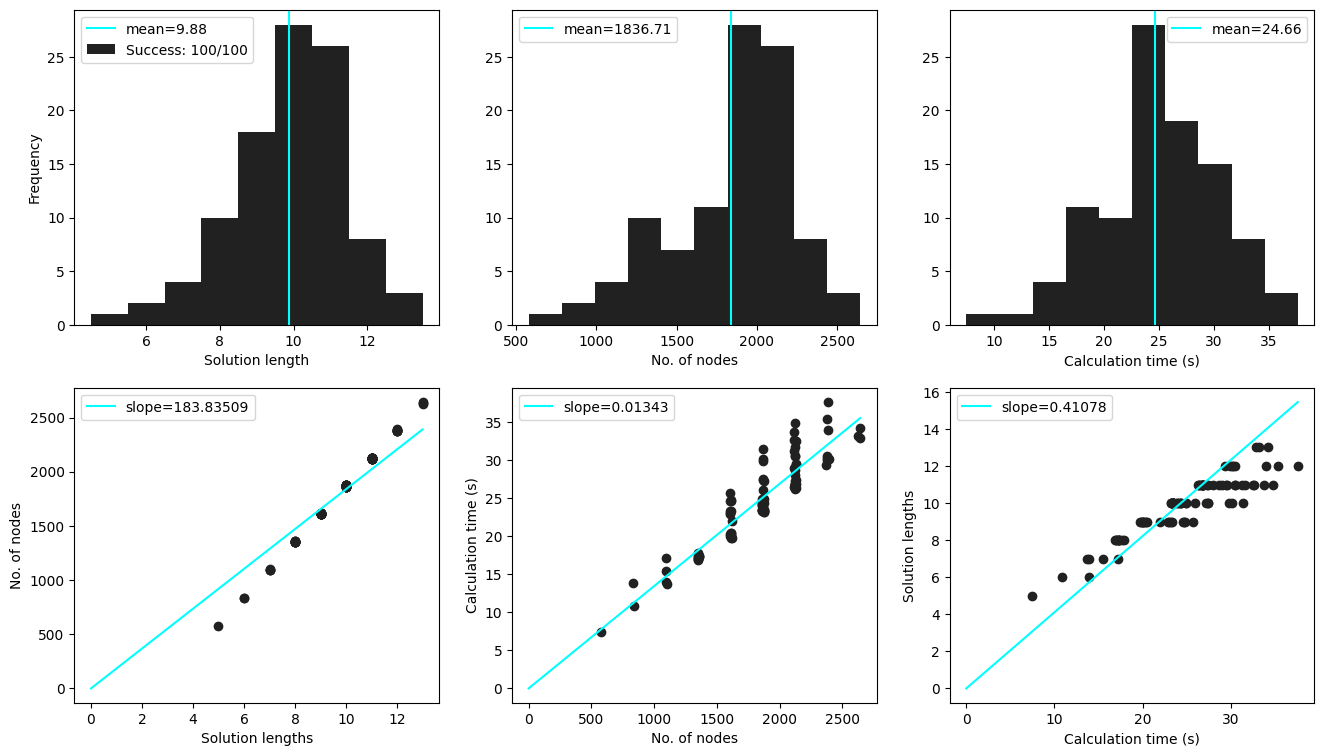

In [109]:
plot_result(*result_all.values())

# 10. The following was used for testing the net, and is not required for any other part.

In [116]:
env_test = Cube2()
env_test.reset()
env_test.apply_scramble("R' U F U F' R U")
env_test.state

array([0, 2, 3, 2, 1, 3, 5, 1, 2, 4, 0, 5, 3, 4, 2, 1, 0, 5, 4, 0, 4, 3,
       5, 1])

In [117]:
print(env_test.state)
success, result = beam_search(env_test, model, max_depth=22, beam_width=2**8)
print(success)
print(result)
print(env_test.state)

[0 2 3 2 1 3 5 1 2 4 0 5 3 4 2 1 0 5 4 0 4 3 5 1]
8/8 [==============================] - 0s 2ms/step
True
{'solutions': ['F2', 'R', "U'", 'F', 'U2', 'R', 'F'], 'num_nodes': 1104, 'times': 14.460190534591675}
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]


In [ ]:
env_test.reset()
env_test.apply_scramble("R' U F U F' R U")
print('state after scramble: ', '\n', env_test.state)
solve = result['solutions']
for m in solve:
    env_test.finger(m)
    print('the move is: ', m, '\n', 'the state is: ', env_test.state)

state after scramble:  
 [0 2 3 2 1 3 5 1 2 4 0 5 3 4 2 1 0 5 4 0 4 3 5 1]
the move is:  F2 
 the state is:  [1 2 3 2 1 3 5 0 2 4 4 3 5 0 2 1 0 5 4 0 1 5 3 4]
the move is:  U' 
 the state is:  [2 2 1 3 1 3 5 0 2 5 4 0 5 5 2 4 0 0 4 1 1 4 3 3]
the move is:  R' 
 the state is:  [2 2 0 0 1 3 3 3 2 5 4 0 5 4 5 2 0 5 4 1 1 4 1 3]
the move is:  U' 
 the state is:  [2 0 2 0 1 3 3 3 2 5 4 1 5 4 5 3 0 4 4 2 1 5 1 0]
the move is:  R 
 the state is:  [2 0 1 0 1 3 4 0 2 5 4 1 5 5 3 4 0 2 4 2 1 5 3 3]
the move is:  F' 
 the state is:  [5 0 5 0 1 1 4 4 2 5 2 1 3 0 3 4 0 2 4 2 5 3 1 3]
the move is:  U' 
 the state is:  [0 0 5 5 1 1 4 4 2 2 2 2 3 3 3 3 0 0 4 4 5 5 1 1]
the move is:  R' 
 the state is:  [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]


In [118]:
model.load_weights('/content/saved_weights/cube2_model')

OpError: ignored